In [1]:
from dependencies import *

_ColormakerRegistry()

# Preprocess data

Read in geometries

In [12]:
soap = SOAP(
    species=species,
    periodic=True,
    rcut=5,
    nmax=10,
    lmax=9,
)
soap.get_number_of_features()

15400

In [ ]:
getSOAPs()

In [8]:
# globals
jitter = True
jitterscale = 0.25
adslen = 5
# adsIdx = 370

species = ["Si", "N", "H", "C", "F", "Ar", "He"]

# specifics
# datadir = "../slab0/"
datadirs = ["temp"]
datadirs = ["../mef.noH.bulk/"]
# datadirs = ['../cf4_adsorb/']

datalist = []
for datadir in datadirs:
    data = readStructs(datadir) #MeF, amorphous slab, DFTB
    data['processed'] = [
        convertAdsorbateToHe(
            i, len(i) - adslen, np.arange(len(i) - adslen, len(i))
        ) for i in data['geom']
    ]

    if jitter:
        np.random.seed(429)
        for struct in data['processed']:
            struct[-1].position[2] += np.random.normal(scale = jitterscale) 
            # add a bit of noise to z coord; reduce overfitting

    data = pd.concat([data, getSOAPs(data['processed'], species = species)], axis = 1)

    originalColumns = data.columns

    datalist += [pd.concat([pd.DataFrame(data['SOAP'].to_list(), index = data.index), data], axis = 1)]
data = pd.concat(datalist).reset_index(drop = True).fillna(0)
data

,0,1,2,3,4,5,6,7,8,9,...,15395,15396,15397,15398,15399,E,E_ads,geom,processed,SOAP
0,4.353228e-11,-9.761211e-10,7.905594e-09,-2.844079e-08,6.282483e-09,1.895700e-07,-1.763073e-07,-2.046005e-07,-1.969790e-07,4.707813e-07,...,0.0,0.0,0.0,0.0,0.0,-16767.6256,-1.5866,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.3532275e-11, -9.761211e-10, 7.9055935e-09, ..."
1,7.607364e-09,-9.992135e-08,5.802353e-07,-1.236764e-06,-1.529618e-06,4.555576e-06,2.258254e-06,-1.302319e-06,1.219160e-07,-5.623986e-06,...,0.0,0.0,0.0,0.0,0.0,-16766.1852,-0.1462,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.607364e-09, -9.992135e-08, 5.8023534e-07, -..."
2,8.391851e-11,4.454390e-10,-8.317685e-09,4.233181e-08,-4.714301e-08,-2.303692e-07,4.270018e-07,6.357941e-08,3.113139e-08,-3.543174e-07,...,0.0,0.0,0.0,0.0,0.0,-16766.2098,-0.1708,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.391851e-11, 4.4543896e-10, -8.317685e-09, 4..."
3,2.847526e-09,-1.677239e-08,4.058898e-08,8.008856e-08,-5.763775e-07,3.532773e-07,1.643088e-07,9.943318e-07,1.858888e-06,-3.459410e-06,...,0.0,0.0,0.0,0.0,0.0,-16766.1837,-0.1447,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.8475262e-09, -1.6772388e-08, 4.0588983e-08,..."
4,3.838045e-09,-3.024889e-08,1.170131e-07,-6.144818e-08,-8.713209e-07,9.953122e-07,6.548893e-07,5.098966e-07,2.522805e-06,-4.764007e-06,...,0.0,0.0,0.0,0.0,0.0,-16766.2209,-0.1819,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.8380454e-09, -3.0248888e-08, 1.17013094e-07..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,2.965279e-09,-1.850123e-08,4.562659e-08,1.195156e-07,-8.266827e-07,4.529262e-07,8.936792e-07,9.714616e-07,6.789587e-07,-2.980368e-06,...,0.0,0.0,0.0,0.0,0.0,-16767.4932,-1.4542,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.965279e-09, -1.8501234e-08, 4.5626585e-08, ..."
64,5.332725e-10,-5.904607e-10,-1.867550e-08,1.310667e-07,-2.385101e-07,-4.916511e-07,1.357381e-06,-3.141832e-07,4.456674e-07,-1.094002e-06,...,0.0,0.0,0.0,0.0,0.0,-16766.1742,-0.1352,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[5.3327254e-10, -5.904607e-10, -1.8675502e-08,..."
65,3.474001e-09,-2.205357e-08,6.058986e-08,8.829564e-08,-8.498182e-07,6.752736e-07,9.445916e-07,-2.467963e-07,2.065028e-06,-3.335990e-06,...,0.0,0.0,0.0,0.0,0.0,-16766.1551,-0.1161,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.4740013e-09, -2.2053573e-08, 6.058986e-08, ..."
66,3.307610e-10,-2.251950e-09,7.274817e-09,1.015500e-08,-1.818418e-07,5.163769e-07,-1.857476e-07,-6.362795e-07,-2.557520e-08,5.786108e-07,...,0.0,0.0,0.0,0.0,0.0,-16766.2013,-0.1623,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.30761e-10, -2.2519502e-09, 7.274817e-09, 1...."


In [19]:
view(data['processed'])

In [5]:
view(data['geom'])

Independent test data:

In [5]:
# data2 = readStructs("../adsorb_amorphous2/", -196.0817, -16286.2542) #MeF, amorphous slab 2, DFTB

# data2['processed'] = [
#     convertAdsorbateToHe(i, 355, np.arange(355, 360)) for i in data2['geom']
# ]

# data2 = pd.concat([data2, getSOAPs(data2['processed'])], axis = 1)

# originalColumns = data2.columns

# data2 = pd.concat([pd.DataFrame(data2['SOAP'].to_list(), index = data2.index), data2], axis = 1)

# Visualize data

Summarize data:

In [27]:
data["E_ads"].describe()

count    68.000000
mean     -0.291743
std       0.415505
min      -1.589000
25%      -0.181750
50%      -0.157100
75%      -0.127050
max      -0.077800
Name: E_ads, dtype: float64

In [31]:
view(data['geom'][279])

In [30]:
view(data.loc[data['E_ads'] < -0.3, originalColumns]['geom'])

In [31]:
data.loc[data['E_ads'] < -0.3, 'E_ads']

0    -1.5866
6    -1.5013
22   -1.4295
24   -1.5890
27   -1.4759
29   -1.4832
32   -0.3032
63   -1.4542
Name: E_ads, dtype: float64

In [32]:
data.loc[np.bitwise_and(data['E_ads'] < 0, data['E_ads'] > -0.1), 'E_ads']

10   -0.0811
15   -0.0778
48   -0.0955
Name: E_ads, dtype: float64

In [33]:
view(data.loc[np.bitwise_and(data['E_ads'] < 0, data['E_ads'] > -0.1), 'geom'])

In [37]:
view(data.loc[6, 'geom'])

In [33]:
view(gen.read_gen('../adsorb_amorphous/output3.gen'))

In [34]:
(data.loc[np.bitwise_and(data['E_ads'] < 0, data['E_ads'] < -0.4), originalColumns])

,E,geom,E_ads,processed,SOAP
6,-17025.2714,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4094,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.0048074e-10, -6.624648e-09, 3.145716e-08, -..."
24,-17025.3206,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...",-0.4586,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.6356706e-09, -1.5346345e-08, 3.7105632e-08,..."


# Adaptive sampling?

# Train

For now, just remove points that have positive adsorption energy 

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
validData = data['E_ads'] < 0
# X_train = data.loc[validData, ~np.isin(data.columns, originalColumns)]
# y_train = data.loc[validData, 'E_ads']
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[validData, ~np.isin(data.columns, originalColumns)], 
    data.loc[validData, 'E_ads'], random_state = 429)
print("# points total: %d; #train points: %d; #test points: %d" % 
      (sum(validData), len(X_train), len(X_test)))

# points total: 300; #train points: 225; #test points: 75


In [6]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,15390,15391,15392,15393,15394,15395,15396,15397,15398,15399
258,1.815447e-12,-3.158739e-11,2.573180e-10,-1.140364e-09,1.270609e-09,1.091704e-08,-4.197369e-08,3.054351e-08,4.419032e-08,-4.674955e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
199,5.606738e-11,5.662895e-10,-8.116053e-09,3.772891e-08,-3.491013e-08,-2.008935e-07,3.164138e-07,1.324712e-08,3.651395e-07,-5.680119e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
284,4.457202e-09,-1.972164e-08,-1.027219e-08,5.218718e-07,-1.835957e-06,5.146284e-07,3.399620e-06,-9.959998e-07,1.100307e-06,-3.564744e-06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
137,6.730261e-13,-1.795998e-11,1.973100e-10,-1.337311e-09,5.522935e-09,-1.329977e-08,2.201634e-08,-4.205664e-08,6.325300e-08,-3.571113e-08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83,3.529154e-09,-2.624558e-08,9.343935e-08,-5.878081e-09,-8.233440e-07,6.133091e-07,1.633452e-06,-5.700138e-07,1.515161e-06,-3.155809e-06,...,0.000124,-0.000112,0.000071,-0.000024,0.000100,-0.000064,0.000022,0.000041,-0.000014,0.000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
141,5.245168e-09,-4.142764e-08,1.625453e-07,-8.473738e-08,-1.453749e-06,2.924227e-06,-8.810478e-07,-5.876803e-07,3.777944e-06,-4.668774e-06,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
98,7.224400e-12,-6.336827e-11,3.545257e-10,-1.199306e-09,1.139600e-09,7.127744e-09,-2.133617e-08,-1.128179e-09,5.313376e-08,-3.973086e-08,...,0.000471,-0.000737,0.000753,-0.000375,0.001154,-0.001178,0.000586,0.001202,-0.000598,0.000298
52,6.504120e-12,-4.308866e-11,9.127864e-11,6.978783e-10,-6.801208e-09,2.194299e-08,-6.673361e-09,-1.170892e-07,2.307847e-07,-1.263461e-07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Run KRR with grid CV search

In [7]:
alphas = np.logspace(-10, -1, 25)
krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
Emodel = GridSearchCV(krr, [{"alpha":alphas}], cv = 5)
Emodel.fit(np.array(X_train), np.array(y_train))

GridSearchCV(cv=5, error_score=nan,
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([1.00000000e-10, 2.37137371e-10, 5.62341325e-10, 1.33352143e-09,
       3.16227766e-09, 7.49894209e-09, 1.77827941e-08, 4.21696503e-08,
       1.00000000e-07, 2.37137371e-07, 5.62341325e-07, 1.33352143e-06,
       3.16227766e-06, 7.49894209e-06, 1.77827941e-05, 4.21696503e-05,
       1.00000000e-04, 2.37137371e-04, 5.62341325e-04, 1.33352143e-03,
       3.16227766e-03, 7.49894209e-03, 1.77827941e-02, 4.21696503e-02,
       1.00000000e-01])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Optimal model result:

In [242]:
Emodel.best_params_

{'alpha': 0.007498942093324558}

In [8]:
import pickle
with open('Emodel_fragments', 'wb') as f:
    pickle.dump(Emodel, f)

## Optimizing SOAP

In [10]:
def predictZs(slabs):
    bareslab = slabs[0].copy()
    del bareslab[-1]
    
    testZstructs = []
    
    for slab in slabs:
        x, y, z = slab[-1].position
        maxz = 0
        for atom in slab:
            if atom.symbol == "He": # don't use He position to determine max Z position 
                continue
            _x, _y, _z = atom.position
            if ((x - _x)**2 + (y - _y)**2) ** 0.5 < 2.2:
                if _z > maxz:
                    maxz = _z

        newstruct = bareslab.copy()
        newheight = maxz + 2.5 #mean height from test; 
        # see https://docs.google.com/presentation/d/13NdBmWkxwG0ZvL7BgYsGo-x-3CzZp8JymnF8yTitdCg/edit#slide=id.ga11af18809_0_13

        newstruct.append(Atom("He", position = (x, y, newheight)))
        testZstructs += [newstruct]    
        
    return testZstructs
# predictZs(data['processed']) == testZstructs

In [58]:
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

def f(args, data):
    np.random.seed(429)
#     rcut,nmax,lmax,sigma, scale = args
#     nmax = int(nmax)
#     lmax = int(lmax)
    rcut, sigma, scale = args
    nmax = 10
    lmax = 9
    for struct in data['processed']:
        struct[-1].position[2] += np.random.normal(scale = scale) # add a bit of noise to z coord; reduce overfitting

    data = pd.concat([data, getSOAPs(data['processed'], 
                                     rcut = rcut, 
                                     nmax = nmax, 
                                     lmax = lmax, 
                                     sigma = sigma
                                    )], axis = 1)

    originalColumns = data.columns

    data = pd.concat([pd.DataFrame(data['SOAP'].to_list(), index = data.index), data], axis = 1)

    validData = data['E_ads'] < 0

    #train KRR on whole dataset
    X_train = data.loc[validData, ~np.isin(data.columns, originalColumns)] 
    Y_train = data.loc[validData, 'E_ads']
#     print(X_train, Y_train)

    alphas = np.logspace(-10, -2, 50)
    krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
    model = GridSearchCV(krr, [{"alpha":alphas}], cv = 5, n_jobs = 4)
    model.fit(np.array(X_train), np.array(Y_train))

    # generate the 'noisy/test' data
    newdata = data[originalColumns]
    newdata = newdata.drop('SOAP', axis = 1)
    newdata['testZstructs'] = predictZs(data['processed'])
    newdata = pd.concat([newdata, 
                         getSOAPs(newdata['testZstructs'],
                                  rcut = rcut,
                                  nmax = nmax, 
                                  lmax = lmax,
                                  sigma = sigma
                                 )], axis = 1)
    newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
    newX = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)

    newdata['testEads'] = model.predict(newX)
    newdata['errors'] = newdata['E_ads'] - newdata['testEads']
    print(np.abs(np.mean(newdata['errors'])), rcut, sigma, scale)

    return np.abs(np.mean(newdata['errors']))

mydata = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
mydata['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in mydata['geom']
]

# guesses = [5, 10, 9, .1, 0.5]
guesses = [5, .1, 0.5]
bounds = [(1, None),
          (0, None),
          (0, None)
]
result = minimize(f, x0 = guesses, args = (mydata), bounds = bounds)

0.0012777788752003972 5.0 0.1 0.5
0.0022917501414224735 5.00000001 0.1 0.5
0.00050135852914354 5.0 0.10000001 0.5
5.5357097479043675e-05 5.0 0.1 0.50000001
6.144074524486362e-05 4.999972378585766 0.6361456999627331 1.3441254572920593
0.016283310356580274 4.999972388585766 0.6361456999627331 1.3441254572920593
0.005245694457853478 4.999972378585766 0.6361457099627331 1.3441254572920593
0.030477123300663975 4.999972378585766 0.6361456999627331 1.3441254672920593
0.0167471184476662 4.9999840133755065 0.41030851304173477 0.9885599483334109
0.018630920060651708 4.999984023375506 0.41030851304173477 0.9885599483334109
0.023372309054812933 4.9999840133755065 0.41030852304173476 0.9885599483334109
0.02558383158889533 4.9999840133755065 0.41030851304173477 0.9885599583334109
0.014844434049679122 4.999990854991042 0.2775092754973011 0.7794764526940281
0.030761909149031326 4.999990864991042 0.2775092754973011 0.7794764526940281
0.041217915481462725 4.999990854991042 0.2775092854973011 0.779476452

In [49]:
result.x

array([5. , 0.1, 0.5])

In [55]:
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]
f([5, .1, 0.5],data)

0.002346843025654266 5 0.1 0.5


0.002346843025654266

In [56]:
f([5, .1, 0.5],data)

0.00394504982176187 5 0.1 0.5


0.00394504982176187

# Assess

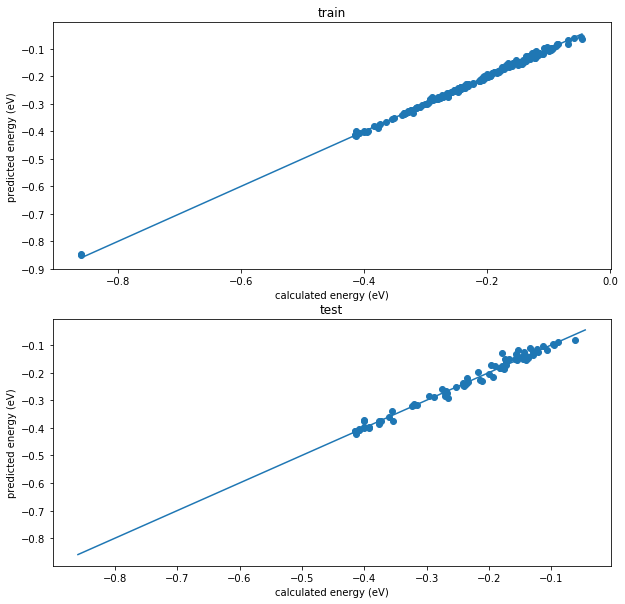

In [91]:
plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
train_predict = Emodel.predict(X_train)
plt.scatter(y_train, train_predict)
lineparams = [min(y_train), max(y_train)]
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("test")
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
plt.scatter(y_test, Emodel.predict(X_test))
plt.plot(lineparams, lineparams);

## Plot residuals

Considering the true model should simply be y = x, we can plot residuals and assess MAE easily:

In [92]:
train_errs = y_train - Emodel.predict(X_train)

In [93]:
test_errs = y_test - Emodel.predict(X_test)

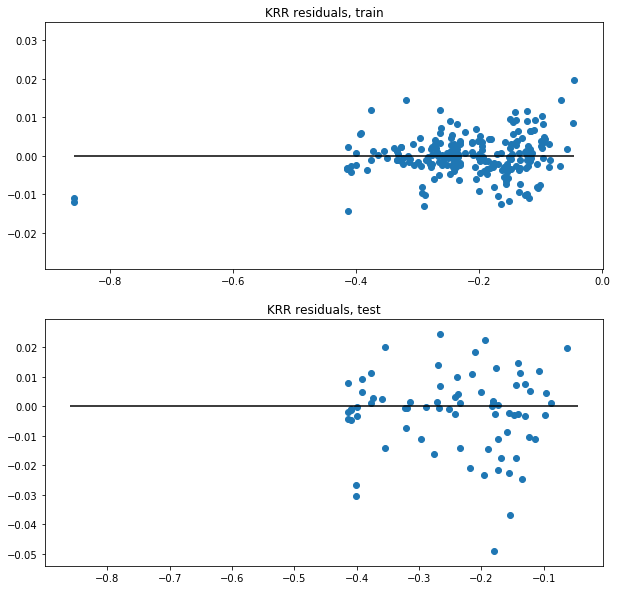

In [94]:
plt.subplots(2, 1, figsize = (10, 10))
plt.subplot(211)
plt.title("KRR residuals, train")
plt.scatter(y_train, train_errs);
plt.hlines(0, *lineparams)
plt.subplot(212)
plt.title("KRR residuals, test")
plt.hlines(0, *lineparams)
plt.scatter(y_test, test_errs);

In [79]:
print("MAE train (eV): %f \n\
MAE test (eV): %f" % 
      (np.mean(np.abs(train_errs)),
       np.mean(np.abs(test_errs))
      ))

MAE train (eV): 0.027097 
MAE test (eV): 0.024433


In [80]:
print("Relative absolute error train (eV): %f \n\
Relative absolute error test (eV): %f" % 
      (np.mean(np.abs(train_errs))/np.abs(np.mean(y_train)),
       np.mean(np.abs(test_errs)/np.abs(np.mean(y_test)))
      ))

Relative absolute error train (eV): 0.123533 
Relative absolute error test (eV): 0.101305


# Apply

Obtain the bare slab:

In [15]:
bareslab = data['processed'][0].copy()
del bareslab[[atom.symbol == 'He' for atom in bareslab]]
view(bareslab)

Try to predict z coordinate based on (x,y) position, using rule based method:

In [79]:
# find optimal rcut
stds = []
for searchR in np.arange(0, 4, 0.1):
    errors = []
    for slab in data['processed']:
        x, y, z = slab[-1].position
        maxz = 0
        for atom in slab:
            if atom.symbol == "He": # don't use He position to determine max Z position 
                continue
            _x, _y, _z = atom.position
            if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
                if _z > maxz:
                    maxz = _z

        errors += [z - maxz]
    stds += [np.std(errors)]
plt.plot(np.arange(0, 4, 0.1), stds)
plt.vlines(2.2, 0.5, 6, label = 'min at 2.2')
plt.legend()
plt.xlabel('radial cutoff')
plt.ylabel('SD of (z_surfmax - z_ads)')

KeyboardInterrupt: 

2.401963612489196


Text(0, 0.5, 'z_surfmax - z_ads')

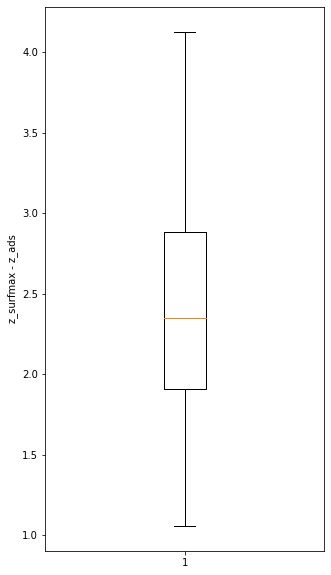

In [81]:
# use optimal rcut to find z offset and generate structs with that offset
plt.figure(figsize = (5,10))
searchR = 2.2
testZstructs = []
actualZstructs = []

errors = []
for slab in data['processed']:
    x, y, z = slab[-1].position
    maxz = 0
    for atom in slab:
        if atom.symbol == "He": # don't use He position to determine max Z position 
            continue
        _x, _y, _z = atom.position
        if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
            if _z > maxz:
                maxz = _z

    errors += [z - maxz]
    newstruct = bareslab.copy()
    newheight = maxz + 2.5 #mean height from test; 
    # see https://docs.google.com/presentation/d/13NdBmWkxwG0ZvL7BgYsGo-x-3CzZp8JymnF8yTitdCg/edit#slide=id.ga11af18809_0_13
    
    newstruct.append(Atom("He", position = (x, y, newheight)))
    testZstructs += [newstruct]    
#     actualZstructs += [bareslab.copy()]
#     add_adsorbate(acutalZstructs[-1], "He", height = 
plt.boxplot(errors)
# plt.legend()
print(np.mean(errors))
plt.ylabel('z_surfmax - z_ads')

## Assess mean error across sampled points

### Using rule based system

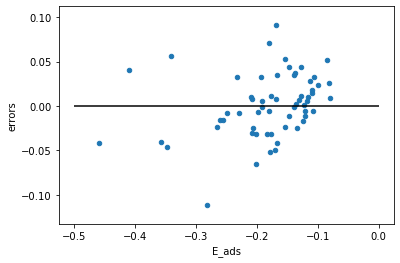

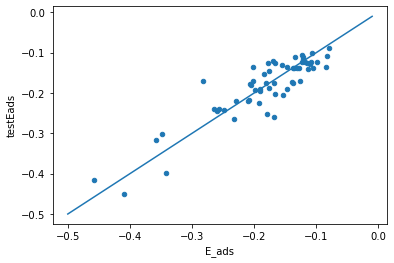

In [82]:
# append newstructs to data
newdata = data[originalColumns]
newdata = newdata.drop('SOAP', axis = 1)
newdata['testZstructs'] = testZstructs
newdata = pd.concat([newdata, 
                     getSOAPs(newdata['testZstructs'])], axis = 1)
newdata_cols = newdata.columns
newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
newX = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)

newdata['testEads'] = model.predict(newX)
newdata['errors'] = newdata['E_ads'] - newdata['testEads']

newdata.plot('E_ads', 'errors', kind = 'scatter')
plt.hlines(0, -0.5, 0)

newdata.plot('E_ads', 'testEads', kind = 'scatter')
plotx = np.arange(-0.5, 0, 0.01)
plt.plot(plotx, plotx)

In [83]:
print("MAE rule-based (eV): %f " % 
      (np.mean(np.abs(newdata["E_ads"] - newdata["testEads"]))
      ))

MAE rule-based (eV): 0.027297 


### By minimizing energy

In [ ]:
# set range around guessed Z position to search for min E
Zrange = 2
# set range around guessed Z position to search for min E
numsearch = 10

newdata = data[originalColumns].drop('SOAP', axis = 1)
newdata['testZstructs'] = testZstructs
newdata = newdata[newdata["E_ads"] < 0] # filter valid structs
i = 0
minZs, minEs = [], []
for struct in newdata['testZstructs']: #iterate through the testZstruct for each original strcut
    
    
    x, y, z = struct[-1].position # assume adsorbate is last thing in list
    tempstructs = []
    zSearch = np.linspace(z - Zrange/2, z + Zrange/2, numsearch)
    for zTemp in zSearch:
        tempstruct = struct.copy()
        tempstruct[-1].position = [x, y, zTemp]
        tempstructs += [tempstruct]
    tempstructs = pd.Series(tempstructs)
    
    tempSOAPs = getSOAPs(tempstructs)
    tempdata = pd.DataFrame(tempSOAPs.to_list())
    tempEs = model.predict(tempdata)
    minE = np.min(tempEs)
#     minZ = zSearch[tempEs == minE][0]
#     minZs += [minZ]
    minEs += [minE]
# newdata['minZ'] = minZs
newdata['minE'] = minEs
# newdata['actualZ'] = [slab[-1].position[-1] for slab in newdata['processed']]
newdata.head()

In [ ]:
newdata.plot('E_ads', 'minE', kind = 'scatter')
plt.plot(newdata['E_ads'], newdata['E_ads'])

In [ ]:
plt.scatter(newdata["E_ads"], newdata["E_ads"] - newdata["minE"])
plt.hlines(0, -0.5, 0)
plt.xlabel("E_ads")
plt.ylabel("E_ads - avg(E_pred)")

In [ ]:
print("MAE min (eV): %f " % 
      (np.mean(np.abs(newdata["E_ads"] - newdata["minE"]))
      ))

# Prediction of z coordinate

Some pseudocode:

    1) Take all training points, isolate their (x,y) coordinates; generate range of points at $ z_{surf} + 2.5 \pm 1 Å $. 
    2) Set $z_true$ for all those points to be actual z value. 
    3) Run the predictive model; hope it works??? 

In [9]:
np.random.seed(429)

zrange = 2 #3
zstep = 0.25 #.25
zdiffs = np.arange(-zrange, zrange, zstep)

# data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB
# validData = data['E_ads'] < 0
# data = data.loc[validData, :]
# data['processed'] = [
#     convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
# ]


# globals
adslen = 5
# adsIdx = 370

# specifics
# datadir = "../slab0/"
datadirs = ["../slab%d/" % i for i in range(5)]
# datadirs = ['../cf4_adsorb/']

datalist = []
for datadir in datadirs:
    data = readStructs(datadir) #MeF, amorphous slab, DFTB
    data['processed'] = [
        convertAdsorbateToHe(
            i, len(i) - adslen, np.arange(len(i) - adslen, len(i))
        ) for i in data['geom']
    ]

    datalist += [data]
data = pd.concat(datalist).reset_index(drop = True).fillna(0)

data['truez'] = [s[-1].position[2] for s in data['processed']]

In [10]:
newdata = data.copy()
newdata = newdata.iloc[0:0]


for idx, row in data.iterrows():
    truez = row['truez']
    for zdiff in zdiffs:
        newrow = row.copy()
        tempStruct = newrow['processed'].copy()
        tempStruct[-1].position[2] = truez + zdiff
        newrow['processed'] = tempStruct
        newdata = newdata.append(newrow) 
    
newdata = newdata.reset_index(drop = True)

newdata = newdata.sample(frac = 1)
newdata.head()

,E,E_ads,geom,processed,truez
134,-17094.2579,-0.1562,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",18.053646
387,-17094.3887,-0.2870,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",20.251200
2007,-17106.1682,-0.2315,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",19.559609
4710,-17102.5218,-0.2455,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",21.711942
3200,-17105.3717,-0.3154,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",21.656793


In [246]:
newdata.shape

(1088, 5)

In [12]:
newdata = newdata[["E", "E_ads", "geom", "processed", "truez"]]
newdata.head()

newdata = pd.concat([newdata, getSOAPs(newdata['processed'], species = species)], axis = 1)

originalColumns = newdata.columns

X = pd.DataFrame(newdata['SOAP'].to_list(), index = newdata.index)
y = newdata['truez']
newdata = pd.concat([X, newdata], axis = 1)
newdata.head()

,0,1,2,3,4,5,6,7,8,9,...,15396,15397,15398,15399,E,E_ads,geom,processed,truez,SOAP
134,4.808112e-11,-2.952992e-09,2.313785e-08,-6.509271e-08,-1.247748e-08,1.021118e-07,1.817500e-07,-8.970070e-08,7.169325e-08,-3.186038e-07,...,4.019595e-07,7.620040e-07,-2.275382e-07,6.794402e-08,-17094.2579,-0.1562,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",18.053646,"[4.8081115e-11, -2.9529923e-09, 2.3137845e-08,..."
387,1.157644e-12,-8.275235e-12,3.110126e-11,-7.592910e-11,3.810700e-10,-3.887778e-09,2.188259e-08,-5.996286e-08,7.540447e-08,-3.443432e-08,...,6.279616e-04,1.310019e-03,-6.740679e-04,3.468404e-04,-17094.3887,-0.2870,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",20.251200,"[1.1576436e-12, -8.275235e-12, 3.110126e-11, -..."
2007,7.741200e-09,1.424161e-09,-2.816745e-07,1.297790e-06,-8.031602e-07,-1.884577e-06,8.175147e-08,-1.079627e-06,-4.137240e-07,4.815311e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-17106.1682,-0.2315,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",19.559609,"[7.7412e-09, 1.4241608e-09, -2.8167452e-07, 1...."
4710,1.106026e-09,7.727417e-09,-9.826697e-08,3.024094e-07,2.273520e-07,-9.016561e-07,-8.558869e-07,6.265334e-07,-6.355109e-07,2.004319e-06,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-17102.5218,-0.2455,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",21.711942,"[1.1060263e-09, 7.727417e-09, -9.826697e-08, 3..."
3200,4.222452e-06,-1.945955e-05,-2.121619e-05,1.727219e-04,1.343031e-06,-5.036493e-05,1.985634e-05,-9.377832e-05,-1.140008e-05,-2.445248e-04,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-17105.3717,-0.3154,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339...",21.656793,"[4.2224524e-06, -1.9459549e-05, -2.1216189e-05..."


In [124]:
with open('newdata.pkl', 'wb') as f:
    pickle.dump(newdata, f)

In [125]:
with open('newdata.pkl', 'rb') as f:
    newdata = pickle.load(f)
print(newdata.shape)

(4800, 15406)


In [13]:
X_train = newdata.loc[:, ~np.isin(newdata.columns, originalColumns)]
y_train = newdata.loc[:, 'truez']
X_train, X_test, y_train, y_test = train_test_split(
    newdata.loc[:, ~np.isin(newdata.columns, originalColumns)], 
    newdata.loc[:, 'truez'], test_size= 0.25, random_state = 429)
print("# points total: %d; #train points: %d; #test points: %d" % 
      (len(newdata), len(X_train), len(X_test)))

# points total: 4800; #train points: 3600; #test points: 1200


In [14]:
## load model
# with open('zmodel.pkl', 'rb') as f:
#     zmodel = pickle.load(f)

#fit model

print(X.shape)

# X = X.sample(frac = 1)
    
alphas = np.logspace(-10, -2, 10)
krr = KernelRidge()  # gamma automatically set by sklearn.metrics.pairwise.rbf_kernel
zmodel = GridSearchCV(krr, [{"alpha":alphas}], cv = 5)
zmodel.fit(np.array(X), np.array(y))

print(zmodel.best_params_)

(4800, 15400)
{'alpha': 0.00016681005372000556}


In [15]:
zpath = 'zmodel_fragments.pkl'
with open(zpath, 'wb') as f:
    pickle.dump(zmodel, f)

In [16]:
with open(zpath, 'rb') as f:
    zmodel = pickle.load(f)

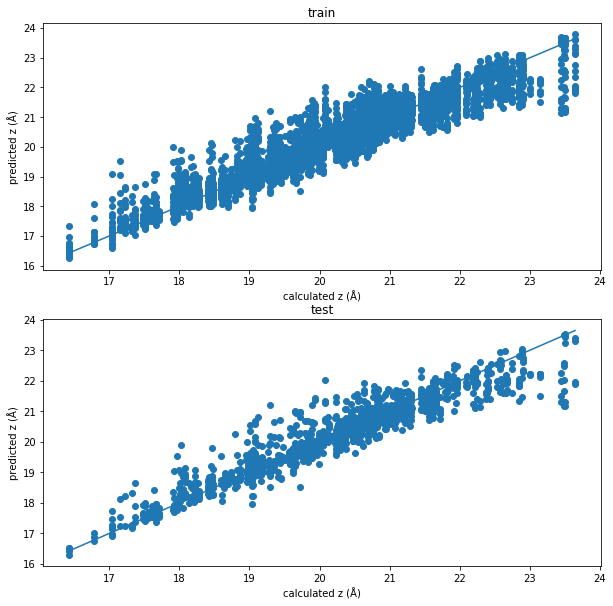

In [17]:
plt.subplots(2, 1, figsize = (10, 10))

# print(X_train.shape)

plt.subplot(211)
plt.title('train')
plt.ylabel("predicted z (Å)")
plt.xlabel("calculated z (Å)")
train_predict = zmodel.predict(X)
plt.scatter(y, train_predict)
lineparams = [min(y), max(y)]
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("test")
plt.ylabel("predicted z (Å)")
plt.xlabel("calculated z (Å)")
plt.scatter(y_test, zmodel.predict(X_test))
plt.plot(lineparams, lineparams);

In [253]:
train_errs = y_train - zmodel.predict(X_train)

In [254]:
test_errs = y_test - zmodel.predict(X_test)

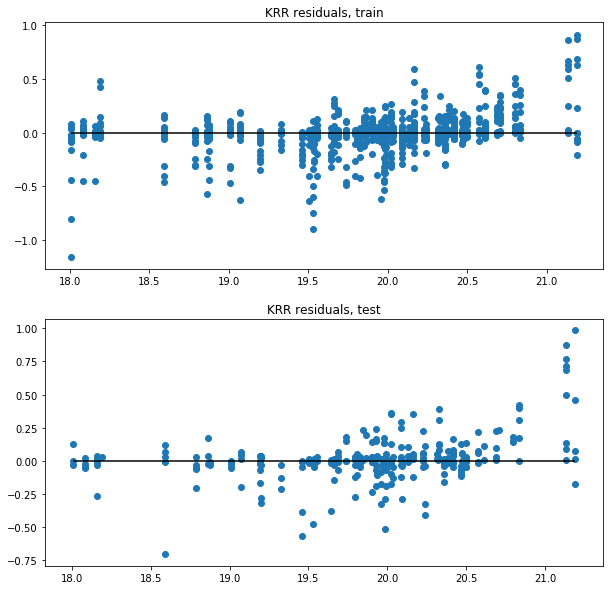

In [255]:
plt.subplots(2, 1, figsize = (10, 10))
plt.subplot(211)
plt.title("KRR residuals, train")
plt.scatter(y_train, train_errs);
plt.hlines(0, *lineparams)
plt.subplot(212)
plt.title("KRR residuals, test")
plt.hlines(0, *lineparams)
plt.scatter(y_test, test_errs);

In [139]:
print("MAE train (Å): %f \n\
MAE test (Å): %f" % 
      (np.mean(np.abs(train_errs)),
       np.mean(np.abs(test_errs))
      ))

MAE train (Å): 0.138398 
MAE test (Å): 0.138437


# Apply both models, chained

First, load the models

In [5]:
with open('zmodel.pkl', 'rb') as f:
    zmodel = pickle.load(f)
with open('Emodel.pkl', 'rb') as f:
    Emodel = pickle.load(f)

Next, read and process the training data that we have:

    1) Read training structures
    2) Filter data to only keep valid data
    3) Convert adsorbates to He points
    4) Use rule-based method and set the height of the He point to be result
    5) Obtain SOAP representation of each training structure, now with He
    6) Get the SOAP matrix and corresponding data for each training structure

In [6]:
np.random.seed(429)
searchR = 2.2

 actual structures (training points) 
data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB

## filter out wrong adsorption energies
validData = data['E_ads'] < 0
data = data.loc[validData, :]

## turn adsorbate molecule 
data['processed'] = [
    convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
]

ztrue = np.array([])

for struct in data['processed']:
    ## calculate initial guess for z position of adsorbate
    
    maxz = 0
    x,y,z = struct[-1].position
    ztrue = np.append(ztrue, z)
    
    for atom in struct:
        if atom.symbol == "He": # don't use He position to determine max Z position 
            continue
        _x, _y, _z = atom.position
        if ((x - _x)**2 + (y - _y)**2) ** 0.5 < searchR:
            if _z > maxz:
                maxz = _z 
    newheight = maxz + 2.5
    
    ## set the rule based guess as the z position of adsorbate
    
    struct[-1].position[2] = newheight 
data['ztrue'] = ztrue
    
originalColumns = data.columns

## generate SOAP representations
    
data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)

# data = data.sample(frac = 1)

## generate data matrix for assessment via ML 
X = pd.DataFrame(data['SOAP'].to_list(), index = data.index)

## generate target vectors

Eads = data['E_ads']
ztrue =  data['ztrue']

First, get KRR predicted z value and show prediction improvement

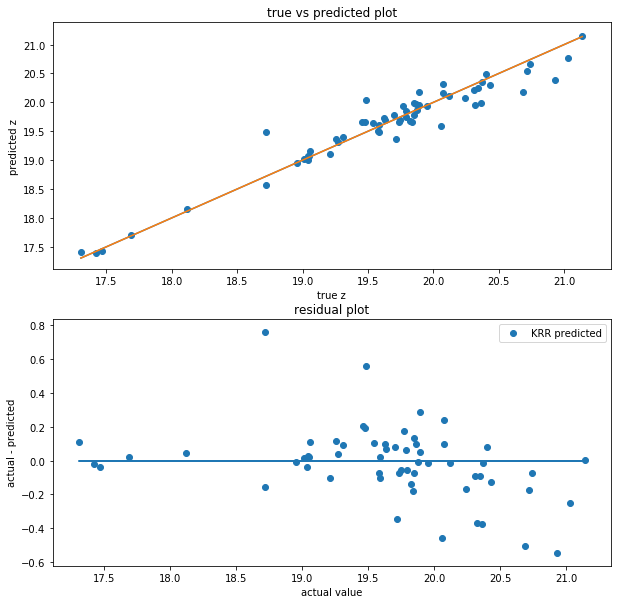

In [7]:
data['predicted z'] = zmodel.predict(X)
lineparams = [min(ztrue), max(ztrue)]
currzs = [atoms[-1].position[2] for atoms in data['processed']]

fig, ax = plt.subplots(2, 1, figsize = (10, 10))

plt.subplot(211)
plt.title('true vs predicted plot')
plt.xlabel("true z")
plt.ylabel("predicted z")
plt.plot(lineparams, lineparams)
plt.scatter(data['ztrue'], data['predicted z'])
plt.plot(lineparams, lineparams)
plt.subplot(212)
plt.title("residual plot")
plt.xlabel("actual value")
plt.ylabel("actual - predicted")
plt.scatter(ztrue, (data['predicted z'] - data['ztrue']), label = 'KRR predicted')
# plt.scatter(ztrue, np.abs(currzs - data['ztrue']), label = 'rule based')
plt.plot(ztrue, ztrue * 0)
plt.legend()


# print("MAE test (Å): %f" % 
#       (np.mean(np.abs(train_predict - Eads)),
#       ))

Replace the z positions with the predicted z; regenerate SOAP for that 

In [8]:
data = data.drop('SOAP', axis = 1)
for i, row in data.iterrows():
    atoms = row['processed']
    row['processed'][-1].position[2] = row['predicted z']
    
data = pd.concat([data, getSOAPs(data['processed'])], axis = 1)


X = pd.DataFrame(data['SOAP'].to_list(), index = data.index)


MAE test (Å): 0.012580


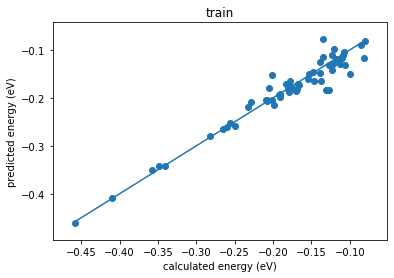

In [9]:
# plt.subplots(2, 1, figsize = (10, 10))

# plt.subplot(211)
plt.title('train')
plt.ylabel("predicted energy (eV)")
plt.xlabel("calculated energy (eV)")
train_predict = Emodel.predict(X)
plt.scatter(Eads, train_predict)
lineparams = [min(Eads), max(Eads)]
plt.plot(lineparams, lineparams)
# plt.subplot(212)
# plt.title("test")
# plt.ylabel("predicted energy (eV)")
# plt.xlabel("calculated energy (eV)")
# plt.scatter(y_test, Emodel.predict(X_test))
# plt.plot(lineparams, lineparams);

print("MAE test (Å): %f" % 
      (np.mean(np.abs(train_predict - Eads)),
      ))

# Use zpred and Epred to map the energy surface

In [15]:
zpath ='zmodel_withC_range2.pkl' 
with open(zpath, 'rb') as f:
    zmodel = pickle.load(f)
with open('Emodel_fragments.pkl', 'rb') as f:
    Emodel = pickle.load(f)

Generate base slab structure

In [16]:
datadirs = ["../slab%d/" % i for i in range(5)]
baseslabs = []

datalist = []
for datadir in datadirs:
    data = readStructs(datadir) #MeF, amorphous slab, DFTB
    data['processed'] = [
        convertAdsorbateToHe(
            i, len(i) - adslen, np.arange(len(i) - adslen, len(i))
        ) for i in data['geom']
    ]

    datalist += [data]
    base = data['processed'].iloc[0].copy()
    del base[[atom.index for atom in base if atom.symbol in ['He', 'Ar']]]
    base.wrap()
    baseslabs += [base]

data = pd.concat(datalist).reset_index(drop = True).fillna(0)

# view(baseslabs)
print(data.shape)

data.head()

(300, 4)


,E,E_ads,geom,processed
0,-17094.4259,-0.3242,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339..."
1,-17094.2084,-0.1067,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339..."
2,-17094.2711,-0.1694,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339..."
3,-17094.2458,-0.1441,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339..."
4,-17094.2840,-0.1823,"(Atom('H', [6.141052145, 11.22574118, 1.215339...","(Atom('H', [6.141052145, 11.22574118, 1.215339..."


In [9]:
# ### read actual structures (training points) 
# data = readStructs("../adsorb_amorphous/", -196.0817, -16828.7803) #MeF, amorphous slab, DFTB

# ## filter out wrong adsorption energies
# validData = data['E_ads'] < 0
# data = data.loc[validData, :]

# ## turn adsorbate molecule 
# data['processed'] = [
#     convertAdsorbateToHe(i, 370, np.arange(370, 375)) for i in data['geom']
# ]

# base = data['processed'][0].copy()
# # base = gen.read_gen("../bomb0/output0-0.gen")
# del base[[atom.index for atom in base if atom.symbol in ['He', 'Ar']]]
# base.wrap()
# view(base)

Grid over surface to map

In [23]:
# assume cubic structure for cell

gridpoints = []
for base in baseslabs:
    a,b,c = base.cell
    a,b,c = np.linalg.norm(a), np.linalg.norm(b), np.linalg.norm(c)
    npoints = 20
    apoints = np.linspace(0, a, npoints)
    bpoints = np.linspace(0, b, npoints)


    _gridpoints = []
    for apoint in apoints:
        for bpoint in bpoints:
            newstruct = base.copy()
            zhat = predictz(newstruct, apoint, bpoint, zmodel = zmodel, species = species)
            newstruct.append(Atom('He', position = (apoint, bpoint, zhat)))
            _gridpoints += [newstruct]


    _gridpoints = pd.Series(_gridpoints)
    _gridpoints = pd.DataFrame({'geom': _gridpoints})
    gridpoints += [_gridpoints]

22.744913780000005 [23.17781226]
22.744913780000005 [22.38042464]
22.744913780000005 [21.98440178]
19.26485912 [19.92443099]
18.31565922 [18.20338419]
18.31565922 [18.13093016]
18.31565922 [19.71532173]
16.57900402 [19.94530869]
16.57900402 [19.16135309]
19.20485324 [20.98117766]
19.20485324 [22.30545269]
19.20485324 [21.99891973]
19.20485324 [21.48888581]
19.20485324 [18.54122037]
20.1686734 [21.15717361]
20.1686734 [21.20419385]
21.714857570000003 [22.53349744]
22.97921959 [21.93672644]
22.97921959 [22.61013505]
22.97921959 [22.71525798]
22.744913780000005 [23.90615478]
22.744913780000005 [23.09586654]
22.744913780000005 [22.26388245]
22.744913780000005 [21.48599483]
18.31565922 [18.84162644]
18.31565922 [18.24987015]
18.31565922 [19.12887284]
18.31565922 [20.35786237]
16.57900402 [18.3732618]
19.20485324 [19.80237107]
19.20485324 [20.63316898]
19.20485324 [22.15409079]
19.20485324 [21.68516952]
19.20485324 [21.04240689]
18.98897645 [21.96188807]
21.714857570000003 [21.96849208]
22.9

20.27299764 [21.22273239]
18.95042538 [22.43082602]
18.95042538 [21.59901408]
18.95042538 [22.30388224]
18.95042538 [21.103963]
18.95042538 [20.88630763]
19.62750394 [20.38981103]
19.62750394 [21.15531815]
20.16335426 [20.27626747]
20.16335426 [20.38445792]
21.00997942 [21.04635652]
20.16335426 [21.55608942]
20.16335426 [21.00477858]
19.55130049 [21.23927034]
18.470304640000002 [20.51453515]
18.470304640000002 [19.58806754]
19.55130049 [19.38615033]
14.76056031 [17.90543591]
20.31314416 [19.84381769]
20.27299764 [20.34392735]
18.95042538 [20.28251471]
18.95042538 [21.18118995]
18.95042538 [21.06587694]
18.95042538 [20.52072107]
18.95042538 [21.15844311]
18.95042538 [20.22441687]
19.62750394 [20.41582518]
19.62750394 [20.72550804]
20.62296404 [20.41405038]
20.62296404 [20.77731888]
21.46245536 [21.98017464]
20.36161618 [21.55608675]
19.55130049 [21.45168901]
19.55130049 [21.10270654]
19.41314443 [20.75013362]
19.41314443 [19.34130159]
19.41314443 [19.30728089]
15.960688330000002 [18.015

19.10661641 [21.42843157]
20.48956592 [21.22691098]
20.09588266 [21.2819087]
20.31017714 [20.8593134]
20.31017714 [20.86603225]
20.31017714 [20.4911938]
20.31017714 [21.05642706]
19.96027528 [20.63231739]
19.96027528 [21.48373028]
22.01543693 [21.11808633]
22.01543693 [21.26614707]
22.01543693 [21.36248634]
19.00334426 [20.10502306]
17.191510980000004 [19.86378212]
17.191510980000004 [19.20602216]
17.91372926 [18.92217002]
16.9212488 [18.30329393]
16.849487520000004 [19.09750032]
20.48956592 [20.56260797]
20.48956592 [21.38564917]
19.10661641 [20.39112993]
19.10661641 [20.4310247]
20.09588266 [21.79672687]
20.31017714 [21.30520319]
20.31017714 [21.09468376]
20.31017714 [20.82848503]
21.65935175 [21.3200357]
21.65935175 [21.27375814]
21.65935175 [21.1615425]
20.92562548 [21.78453492]
20.92562548 [21.41680147]
20.92562548 [21.23119854]
22.01543693 [21.43044256]
20.339436170000003 [19.84788044]
16.9212488 [19.26377886]
16.9212488 [19.48840429]
16.9212488 [19.01153582]
16.849487520000004 [

21.80068751 [22.899353]
21.80068751 [23.15130726]
21.80068751 [23.18912961]
21.75291282 [22.43755215]
21.75291282 [21.70652181]
16.966379970000002 [19.76671869]
19.348560590000005 [20.59770317]
19.348560590000005 [20.73642415]
19.348560590000005 [20.48769919]
19.348560590000005 [21.30411829]
20.5281915 [21.72478996]
20.5281915 [22.06550088]
20.5281915 [22.01561163]
20.5281915 [22.30912802]
21.384230640000002 [21.40141853]
17.508334480000002 [17.67765104]
17.508334480000002 [18.57099114]
17.508334480000002 [18.7196471]
21.29995789 [21.9757044]
21.80068751 [22.54304822]
21.80068751 [23.14947431]
21.80068751 [23.55787789]
22.828969220000005 [22.30701573]
22.828969220000005 [22.03924465]
19.32337708 [21.40757062]
19.32337708 [19.64330941]
19.348560590000005 [20.07746946]
19.348560590000005 [20.99194082]
19.348560590000005 [20.80086512]
19.348560590000005 [22.01687428]
17.12552677 [17.3081691]
19.70352954 [21.29102271]
21.384230640000002 [21.81428372]
21.384230640000002 [21.6924801]
17.5083

20.13304091 [20.16840735]
20.13304091 [21.38618963]
22.112274980000002 [21.92334686]
22.112274980000002 [22.82524802]
22.112274980000002 [22.91338088]
20.673043 [22.87889107]
20.673043 [22.54814377]
20.673043 [21.63869766]
20.673043 [22.56686947]
20.673043 [23.03517937]
21.85074176 [20.35304388]
18.7658434 [20.8330767]
19.44685334 [20.74313509]
19.44685334 [19.71457986]
19.44685334 [19.98296165]
19.44685334 [20.72984819]
18.46702235 [21.64361062]
20.97798827 [20.6490734]
20.97798827 [20.86939815]
20.97798827 [21.15509235]
20.13304091 [20.81395963]
19.21972926 [20.4485171]
22.112274980000002 [22.17279206]
22.112274980000002 [22.65508428]
22.112274980000002 [23.00050513]
20.673043 [23.55447492]
22.112274980000002 [23.22362321]
22.73505964 [21.75531183]
21.95228576 [22.41692313]
21.95228576 [21.92990601]
21.95228576 [21.22250985]
22.79201578 [21.54987175]
20.85790619 [21.5524067]
20.85790619 [21.06171743]
19.44685334 [21.03985983]
18.46702235 [20.76462406]
18.46702235 [20.53130579]
20.977

22.527853010000005 [21.34766919]
19.60574467 [20.77371746]
19.60574467 [19.69274057]
14.8146761 [19.85339913]
19.31971162 [19.3460777]
19.31971162 [19.33311552]
19.31971162 [19.65409796]
19.31971162 [19.72638531]
18.32169511 [19.23735945]
18.32169511 [19.85500544]
20.126200290000003 [20.33527936]
20.30364392 [20.62417698]
19.9055057 [19.6618975]
19.9055057 [19.54719236]
17.7612944 [20.896821]
20.59806521 [20.59685331]
20.59806521 [21.17502372]
21.3767467 [21.56926861]
21.3767467 [21.63103642]
22.527853010000005 [20.83887729]
22.527853010000005 [20.72463779]
19.58888754 [19.74287559]
19.60574467 [19.21051531]
20.3379717 [19.00894836]
19.31971162 [20.27086318]
19.31971162 [19.90816844]
19.31971162 [19.89757901]
16.955040020000002 [20.80002598]
18.32169511 [19.58217519]
18.32169511 [20.85424118]
18.32169511 [21.12993883]
20.126200290000003 [20.83934907]
20.30364392 [19.43934016]
17.81923562 [19.11403444]
20.30364392 [19.92524093]
20.59806521 [20.58338867]
21.3767467 [21.58842862]
21.37674

KeyboardInterrupt: 

In [198]:
with open('gridpoints.pkl', 'wb') as f:
    pickle.dump(gridpoints, f)

In [161]:
view(gridpoints[1]['geom'])

In [171]:
view(gridpoints[0]['geom'][0])

In [182]:
view(gridpoints[0]['geom'][0])

In [178]:
len(getSOAPs(gridpoints[0]['geom'])[0])

15400

In [199]:
gridpoints_dfs = [pd.concat([i, getSOAPs(i['geom'])], axis = 1) 
              for i in gridpoints]
gridpoints_dfs[0].head()

,geom,SOAP
0,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.004225e-08, -3.2115395e-07, 2.1015839e-07, ..."
1,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[5.6426088e-12, -1.6839649e-10, 1.4222811e-09,..."
2,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[9.25844e-10, -3.2435095e-09, -9.628624e-09, 1..."
3,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.9114322e-09, 1.17317445e-08, -2.0268891e-07..."
4,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.8485478e-09, -1.2005167e-08, -1.0927992e-08..."


In [200]:
Xs = [pd.DataFrame(i['SOAP'].to_list(), index = i.index) for i in gridpoints_dfs]
Xs[0].head()

,0,1,2,3,4,5,6,7,8,9,...,15390,15391,15392,15393,15394,15395,15396,15397,15398,15399
0,7.004225e-08,-3.211539e-07,2.101584e-07,3.432295e-06,-2.980652e-06,-9.307265e-06,-3.354767e-06,9.228272e-06,-7.605903e-06,1.848075e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.642609e-12,-1.683965e-10,1.422281e-09,-5.136852e-09,3.752760e-10,4.284997e-08,-7.215085e-08,3.890247e-08,-8.654467e-08,9.102256e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.258440e-10,-3.243509e-09,-9.628624e-09,1.316131e-07,-3.586892e-07,-1.985860e-07,1.502827e-06,-1.411944e-06,1.393362e-06,-1.243065e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.911432e-09,1.173174e-08,-2.026889e-07,7.905552e-07,-3.057746e-07,-1.512161e-06,-1.893466e-07,1.209419e-06,-2.041668e-06,3.187194e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.848548e-09,-1.200517e-08,-1.092799e-08,3.326298e-07,-1.031892e-06,-1.691209e-07,2.250036e-06,3.470285e-07,7.772144e-07,-3.185645e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [201]:
predEs = [Emodel.predict(X) for X in Xs]

In [212]:
for i, j in zip(gridpoints_dfs, predEs):
    i['predE'] = j
gridpoints_dfs[0].head()

,geom,SOAP,predE
0,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[7.004225e-08, -3.2115395e-07, 2.1015839e-07, ...",-0.193910
1,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[5.6426088e-12, -1.6839649e-10, 1.4222811e-09,...",-0.136332
2,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[9.25844e-10, -3.2435095e-09, -9.628624e-09, 1...",-0.146350
3,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.9114322e-09, 1.17317445e-08, -2.0268891e-07...",-0.134773
4,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.8485478e-09, -1.2005167e-08, -1.0927992e-08...",-0.208329


In [213]:
visbases = []
for i, j in zip(baseslabs, gridpoints_dfs):
    charges = np.append(np.zeros(len(i)), j['predE'])
    visbase = i.copy()
    for geom in j['geom']:
        visbase.append(Atom("He", position = geom[-1].position)) 
    visbase.set_initial_charges(charges)
    visbases += [visbase]
view(visbases)

In [256]:
view(visbases)

In [20]:
min(charges), max(charges)

(-0.4370635688632092, 0.0)

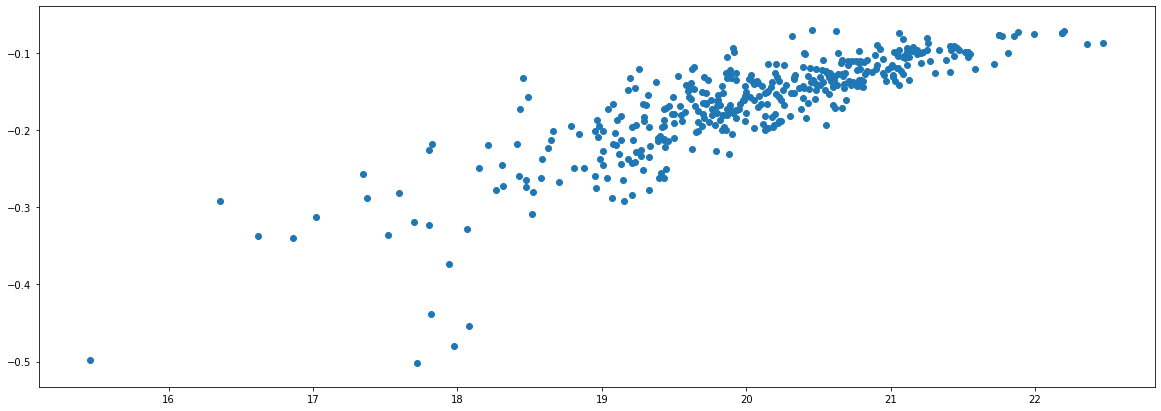

(0.8396398278672665, 1.4900939795625467e-107)


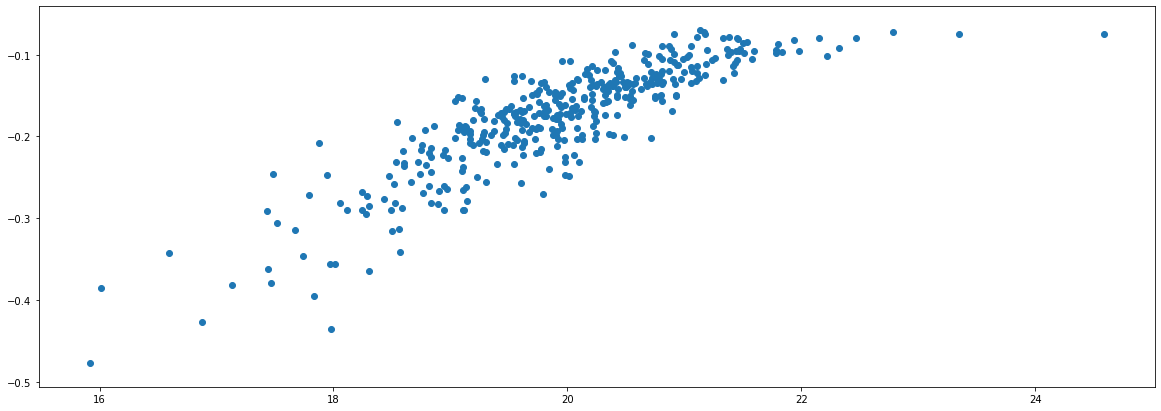

(0.861387174447881, 3.824170000748275e-119)


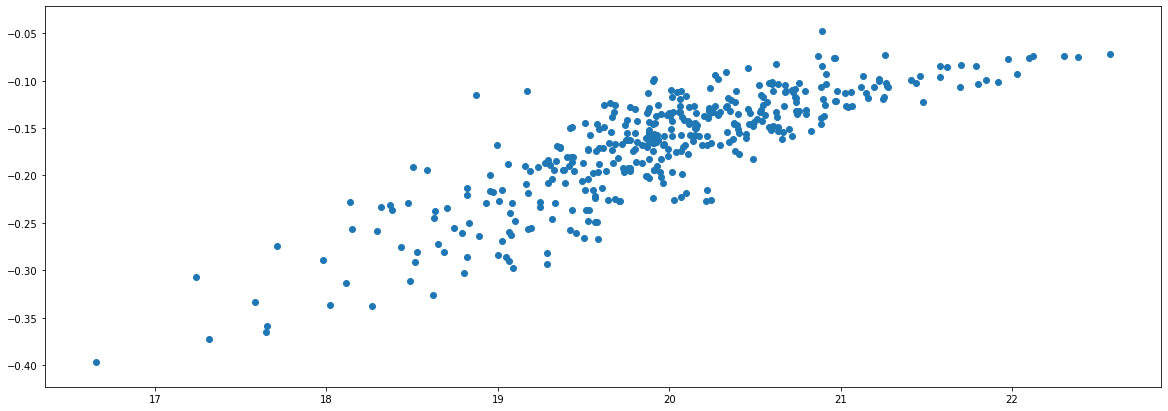

(0.8381372305245522, 8.117209210041773e-107)


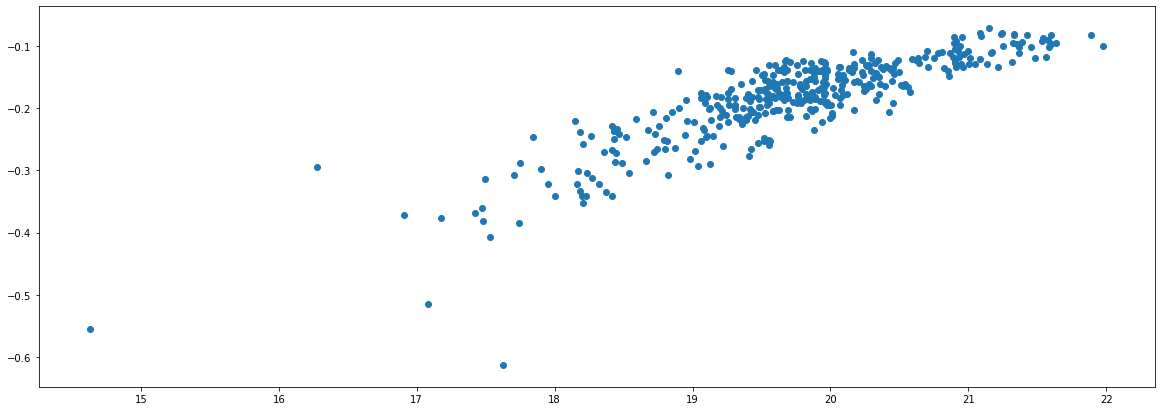

(0.8638228282277429, 1.4528171719939441e-120)


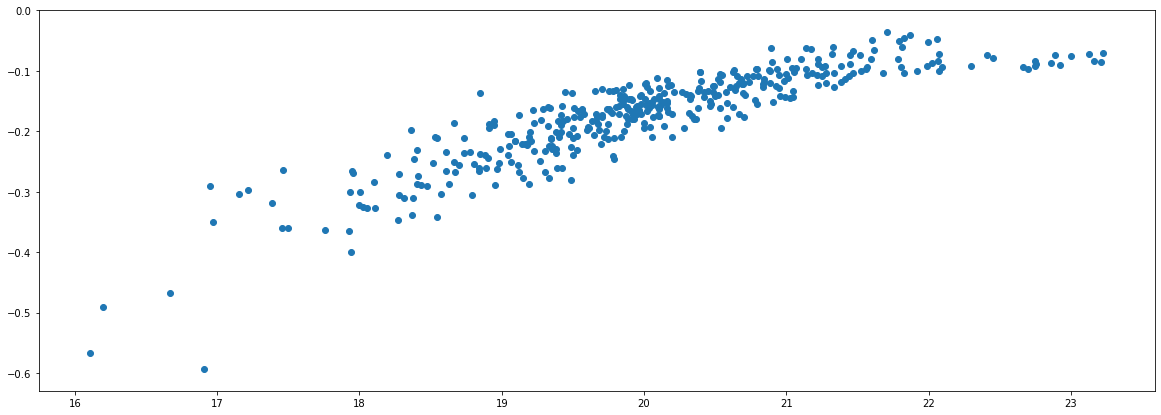

(0.8784616170335122, 1.0053618535486293e-129)


In [208]:
from scipy.stats import pearsonr 
for i in gridpoints:
    plt.scatter([geom[-1].position[2] for geom in i['geom']],
             i['predE']
            )
    plt.show()
    print(
    pearsonr([geom[-1].position[2] for geom in i['geom']],
             i['predE']
            )
    )

# Adaptive sampling based on Epred

In [214]:
for i, val in enumerate(gridpoints_dfs):
    gridpoints_dfs[i] = val.sort_values(by = 'predE')
gridpoints_dfs[0]

,geom,SOAP,predE
377,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.3365887e-09, 1.9650301e-08, -2.1144331e-07,...",-0.502441
306,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.0601693e-15, -1.8019449e-12, 2.0491081e-11,...",-0.498455
81,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.0957588e-06, -1.4019675e-05, -1.3837271e-06...",-0.479263
102,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.026489e-06, -8.509304e-06, -9.202264e-06, 5...",-0.454075
143,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[0.0065697297, -0.003354505, -0.010326623, -0....",-0.438138
...,...,...,...
47,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.332621e-12, -1.0450656e-11, 5.960025e-11, -...",-0.074960
169,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.2296717e-12, -3.608603e-11, 2.3843286e-10, ...",-0.073415
268,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.030823e-12, -7.1355415e-11, 5.24325e-10, -3...",-0.072530
226,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.112578e-09, -6.789572e-10, -2.6393116e-07, ...",-0.072497


In [215]:
for i in gridpoints_dfs:
    i['xpos'] = [geom[-1].position[0] for geom in i['geom']]
    i['ypos'] = [geom[-1].position[1] for geom in i['geom']]
    i['zpos'] = [geom[-1].position[2] for geom in i['geom']]

In [216]:
gridpoints_dfs[0]

,geom,SOAP,predE,xpos,ypos,zpos
377,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.3365887e-09, 1.9650301e-08, -2.1144331e-07,...",-0.502441,14.267179,13.474558,17.717990
306,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.0601693e-15, -1.8019449e-12, 2.0491081e-11,...",-0.498455,11.889316,4.755726,15.453934
81,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[3.0957588e-06, -1.4019675e-05, -1.3837271e-06...",-0.479263,3.170484,0.792621,17.975896
102,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[2.026489e-06, -8.509304e-06, -9.202264e-06, 5...",-0.454075,3.963105,1.585242,18.078412
143,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[0.0065697297, -0.003354505, -0.010326623, -0....",-0.438138,5.548347,2.377863,17.816379
...,...,...,...,...,...,...
47,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[1.332621e-12, -1.0450656e-11, 5.960025e-11, -...",-0.074960,1.585242,5.548347,22.189038
169,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[4.2296717e-12, -3.608603e-11, 2.3843286e-10, ...",-0.073415,6.340968,7.133590,21.882445
268,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.030823e-12, -7.1355415e-11, 5.24325e-10, -3...",-0.072530,10.304074,6.340968,22.202124
226,"(Atom('H', [5.687816897, 11.8095906, 0.4501787...","[8.112578e-09, -6.789572e-10, -2.6393116e-07, ...",-0.072497,8.718832,4.755726,20.618492


In [219]:
adsorbatePoints = []
mefCutoff = 4
for i, j in zip(gridpoints_dfs, visbases):
    _adsorbatePoints = []
    a = j.cell[0]
    b = j.cell[1]
    for i, row in i.iterrows():
        isclose = False
        point1 = np.array([row['xpos'], row['ypos']]) 
        for x, y, z in _adsorbatePoints: 
            for dispx in [-a, a*0, a]:
                for dispy in [-b, b*0, b]:
                    point2 = np.array([x, y])
                    point2 = point2 + dispx[:2] + dispy[:2]

                    if np.linalg.norm(point1 - point2) < mefCutoff:
                        isclose = True
        if not isclose:
            _adsorbatePoints.append(np.append(point1, row['zpos']))
    print(_adsorbatePoints, len(_adsorbatePoints))
    adsorbatePoints += [_adsorbatePoints]

[array([14.26717909, 13.47455803, 17.71798969]), array([11.88931591,  4.75572636, 15.45393372]), array([ 3.17048424,  0.79262106, 17.9758956 ]), array([ 8.71883167, 11.88931591, 17.93987436]), array([ 4.75572636,  6.34096848, 16.61615185]), array([ 0.        ,  9.51145273, 19.15182571]), array([ 7.92621061,  2.37786318, 19.89089693]), array([ 0.79262106,  5.54834742, 20.73254907]), array([ 3.9631053 , 10.30407379, 20.40569568])] 9
[array([ 7.13358954,  4.75572636, 15.9153871 ]), array([ 7.92621061, 14.26717909, 17.97965984]), array([15.05980015,  3.17048424, 16.01570008]), array([14.26717909, 14.26717909, 18.3052624 ]), array([ 0.        ,  7.92621061, 17.97447493]), array([ 3.9631053 ,  0.        , 19.98194725]), array([ 3.9631053 ,  8.71883167, 18.79146826]), array([11.09669485, 10.30407379, 19.77679001]), array([11.09669485,  2.37786318, 19.97613811])] 9
[array([ 7.13358954, 11.88931591, 16.65652977]), array([ 4.75572636,  5.54834742, 17.31710251]), array([14.26717909, 14.26717909, 

In [220]:
adsorbatePoints

[[array([14.26717909, 13.47455803, 17.71798969]),
  array([11.88931591,  4.75572636, 15.45393372]),
  array([ 3.17048424,  0.79262106, 17.9758956 ]),
  array([ 8.71883167, 11.88931591, 17.93987436]),
  array([ 4.75572636,  6.34096848, 16.61615185]),
  array([ 0.        ,  9.51145273, 19.15182571]),
  array([ 7.92621061,  2.37786318, 19.89089693]),
  array([ 0.79262106,  5.54834742, 20.73254907]),
  array([ 3.9631053 , 10.30407379, 20.40569568])],
 [array([ 7.13358954,  4.75572636, 15.9153871 ]),
  array([ 7.92621061, 14.26717909, 17.97965984]),
  array([15.05980015,  3.17048424, 16.01570008]),
  array([14.26717909, 14.26717909, 18.3052624 ]),
  array([ 0.        ,  7.92621061, 17.97447493]),
  array([ 3.9631053 ,  0.        , 19.98194725]),
  array([ 3.9631053 ,  8.71883167, 18.79146826]),
  array([11.09669485, 10.30407379, 19.77679001]),
  array([11.09669485,  2.37786318, 19.97613811])],
 [array([ 7.13358954, 11.88931591, 16.65652977]),
  array([ 4.75572636,  5.54834742, 17.31710251])

In [225]:
adsvisbases = []
idx = 0
for i, j in zip(baseslabs, adsorbatePoints):
    adsvisbase = i.copy()
    maxz = np.max([atom.position[2] for atom in adsvisbase])
    for point in j:
        add_adsorbate(adsvisbase, mef, height = point[2] - maxz + 1, position = (point[0], point[1]))

    gen.write_gen("../input%d.gen" % idx, adsvisbase)
    idx += 1
    adsvisbases += [adsvisbase]
view(adsvisbasesng)